
# MNIST Adversarial Attack Playground

This notebook implements the adversarial attacks emphasized in lecture using the provided MNIST MLP. Each section keeps the attack code and its evaluation together so you can rehearse the mechanics before the midterm.


In [3]:

import json
import math
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from model import get_model
import utils

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

plt.style.use("seaborn-v0_8")
print(f"Using device: {device}")


Using device: cpu


In [4]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

subset_size = 256
print(f"Evaluating on the first {subset_size} MNIST test samples")

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(subset_size))
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=subset_size, shuffle=False)

x_test, y_test = next(iter(test_loader))
x_test = x_test.view(x_test.size(0), -1).to(device)
y_test = y_test.to(device)

print(f"Loaded {x_test.shape[0]} samples")
print(f"Flattened dimension: {x_test.shape[1]}")
print(f"Data range: {x_test.min():.3f} to {x_test.max():.3f}")


Evaluating on the first 256 MNIST test samples


100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 2.60MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 9.03MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 930kB/s]


Loaded 256 samples
Flattened dimension: 784
Data range: 0.000 to 1.000


In [5]:

model = get_model(pretrained_path="data/model.pth", device=device)
clean_accuracy = utils.accuracy(model, x_test, y_test)
print(f"Clean accuracy on this subset: {clean_accuracy:.4f}")


Clean accuracy on this subset: 0.9648


In [6]:

attack_results = {}

def clamp_unit(x):
    return torch.clamp(x, 0.0, 1.0)

def project_linf(delta, eps):
    return torch.clamp(delta, -eps, eps)

def compute_attack_metrics(x_adv, x_clean=x_test, y_clean=y_test):
    with torch.no_grad():
        adv_logits = model(x_adv)
        adv_preds = adv_logits.argmax(dim=1)
    adv_acc = (adv_preds == y_clean).float().mean().item()
    delta = x_adv - x_clean
    linf = delta.abs().max(dim=1)[0].mean().item()
    l2 = torch.norm(delta, p=2, dim=1).mean().item()
    return adv_acc, linf, l2

def log_attack(name, x_adv, notes=None):
    adv_acc, linf, l2 = compute_attack_metrics(x_adv)
    attack_results[name] = {
        "clean_acc": clean_accuracy,
        "adv_acc": adv_acc,
        "avg_linf": linf,
        "avg_l2": l2,
        "notes": notes or ""
    }
    print(f"{name} -> adv accuracy: {adv_acc:.4f} | mean L_inf: {linf:.4f} | mean L2: {l2:.4f}")

def visualize_examples(name, x_adv, num_examples=5):
    num_examples = min(num_examples, x_adv.size(0))
    clean_imgs = x_test[:num_examples].detach().cpu().reshape(-1, 28, 28)
    adv_imgs = x_adv[:num_examples].detach().cpu().reshape(-1, 28, 28)
    diff = adv_imgs - clean_imgs
    vmax = diff.abs().max().item() or 1.0
    fig, axes = plt.subplots(3, num_examples, figsize=(num_examples * 2.2, 6))
    for idx in range(num_examples):
        axes[0, idx].imshow(clean_imgs[idx], cmap="gray")
        axes[0, idx].set_title(f"Clean {idx}")
        axes[0, idx].axis("off")

        axes[1, idx].imshow(adv_imgs[idx], cmap="gray")
        axes[1, idx].set_title("Adv")
        axes[1, idx].axis("off")

        axes[2, idx].imshow(diff[idx], cmap="seismic", vmin=-vmax, vmax=vmax)
        axes[2, idx].set_title("Perturb")
        axes[2, idx].axis("off")
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()



## Fast Gradient Sign Method (FGSM)

One-step untargeted attack that perturbs each pixel in the sign of the loss gradient.


FGSM (eps=0.25) -> adv accuracy: 0.1094 | mean L_inf: 0.2500 | mean L2: 5.3348


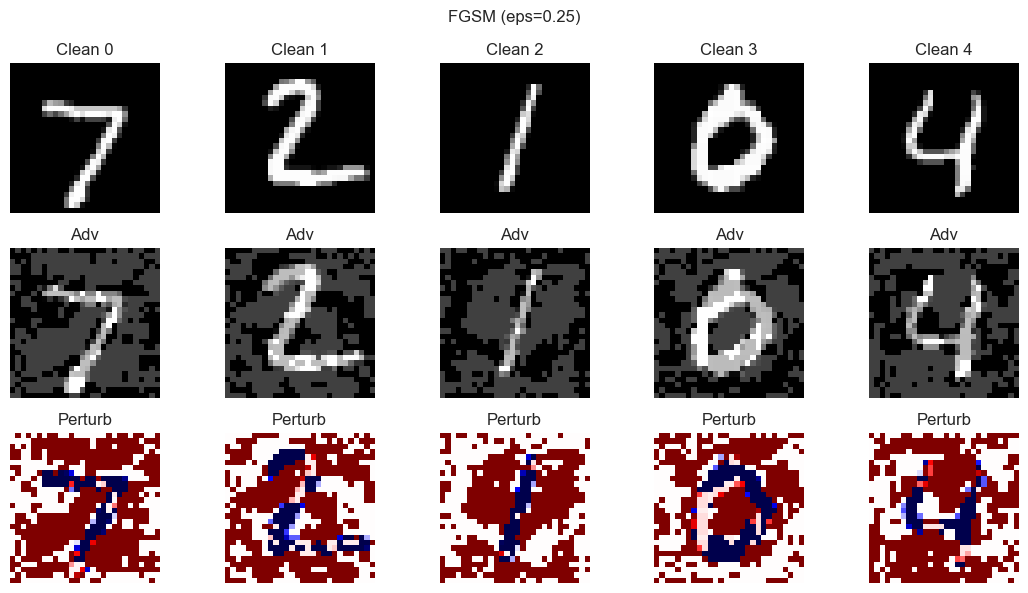

In [8]:

epsilon = 0.25

def fgsm_attack(model, x, y, eps):
    x_adv = x.detach().clone().requires_grad_(True)
    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)
    model.zero_grad()
    loss.backward()
    grad_sign = x_adv.grad.sign()
    x_adv = clamp_unit(x_adv + eps * grad_sign)
    return x_adv.detach()

x_adv_fgsm = fgsm_attack(model, x_test, y_test, epsilon)
log_attack(f"FGSM (eps={epsilon})", x_adv_fgsm, notes="One-step untargeted attack")
visualize_examples(f"FGSM (eps={epsilon})", x_adv_fgsm)



## Basic Iterative Method (I-FGSM / BIM)

Iterative FGSM that keeps the perturbation inside an $L_\infty$ ball.


BIM (eps=0.25, alpha=0.03, steps=10) -> adv accuracy: 0.0039 | mean L_inf: 0.2500 | mean L2: 4.2369


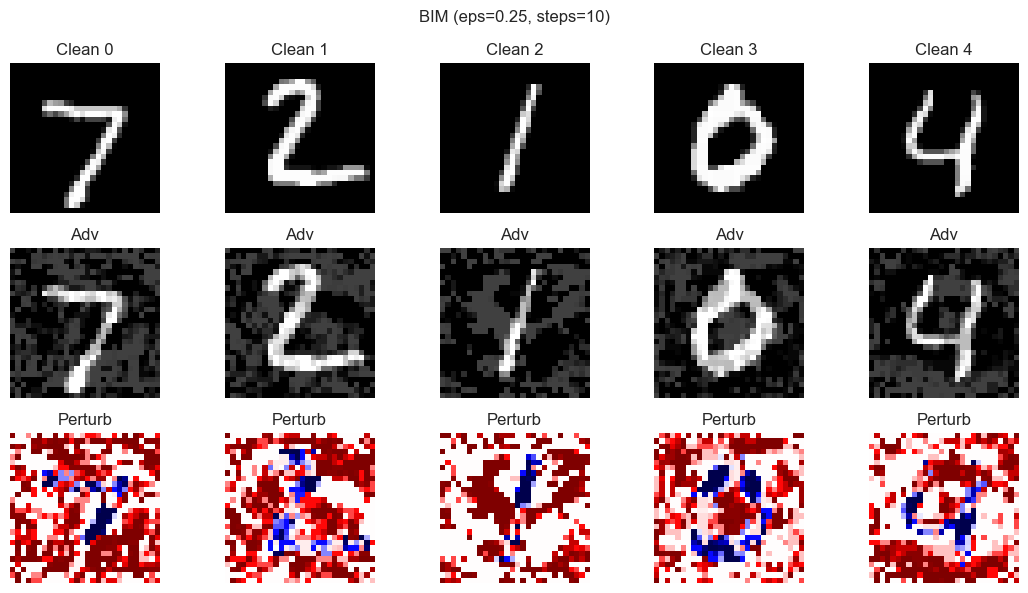

In [10]:

epsilon = 0.25
alpha = 0.03
steps = 10

def bim_attack(model, x, y, eps, alpha, steps):
    x_adv = x.detach().clone()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        model.zero_grad()
        loss.backward()
        grad_sign = x_adv.grad.sign()
        x_adv = x_adv + alpha * grad_sign
        x_adv = clamp_unit(x + project_linf(x_adv - x, eps)).detach()
    return x_adv

x_adv_bim = bim_attack(model, x_test, y_test, epsilon, alpha, steps)
log_attack(f"BIM (eps={epsilon}, alpha={alpha}, steps={steps})", x_adv_bim, notes="Iterative FGSM / Basic iterative attack")
visualize_examples(f"BIM (eps={epsilon}, steps={steps})", x_adv_bim)



## Projected Gradient Descent (PGD)

Multi-step $L_\infty$ attack with random restarts (Madry et al.).


PGD (eps=0.3, steps=40, restarts=5) -> adv accuracy: 0.0000 | mean L_inf: 0.3000 | mean L2: 5.9769


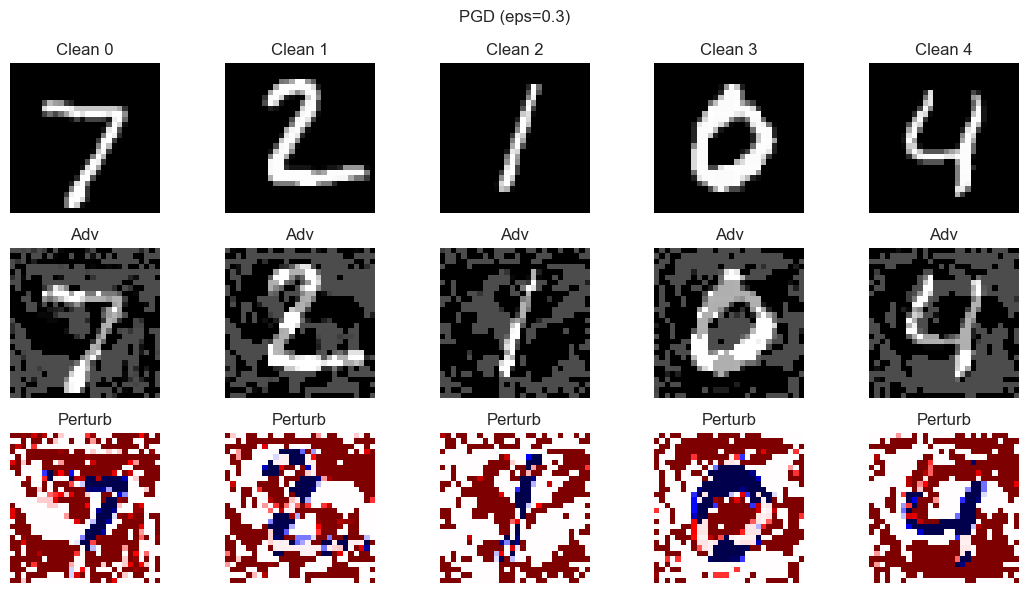

In [12]:

epsilon = 0.30
alpha = 0.03
steps = 40
restarts = 5

def pgd_attack(model, x, y, eps, alpha, steps, restarts=1):
    best_adv = x.clone()
    best_losses = torch.full((x.size(0),), -1e9, device=x.device)
    for _ in range(restarts):
        x_adv = x + torch.empty_like(x).uniform_(-eps, eps)
        x_adv = clamp_unit(x_adv)
        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(x_adv)
            loss = F.cross_entropy(logits, y)
            model.zero_grad()
            loss.backward()
            grad = x_adv.grad.sign()
            x_adv = x_adv + alpha * grad
            x_adv = clamp_unit(x + project_linf(x_adv - x, eps)).detach()
        with torch.no_grad():
            logits = model(x_adv)
            losses = F.cross_entropy(logits, y, reduction="none")
            mask = losses > best_losses
            best_adv[mask] = x_adv[mask]
            best_losses[mask] = losses[mask]
    return best_adv

x_adv_pgd = pgd_attack(model, x_test, y_test, epsilon, alpha, steps, restarts)
log_attack(f"PGD (eps={epsilon}, steps={steps}, restarts={restarts})", x_adv_pgd, notes="Madry PGD with random restarts")
visualize_examples(f"PGD (eps={epsilon})", x_adv_pgd)



## Momentum Iterative FGSM (MI-FGSM)

Augments the iterative attack with a momentum term to stabilize the gradient signal.


MI-FGSM (eps=0.3, steps=20) -> adv accuracy: 0.0039 | mean L_inf: 0.3000 | mean L2: 5.9012


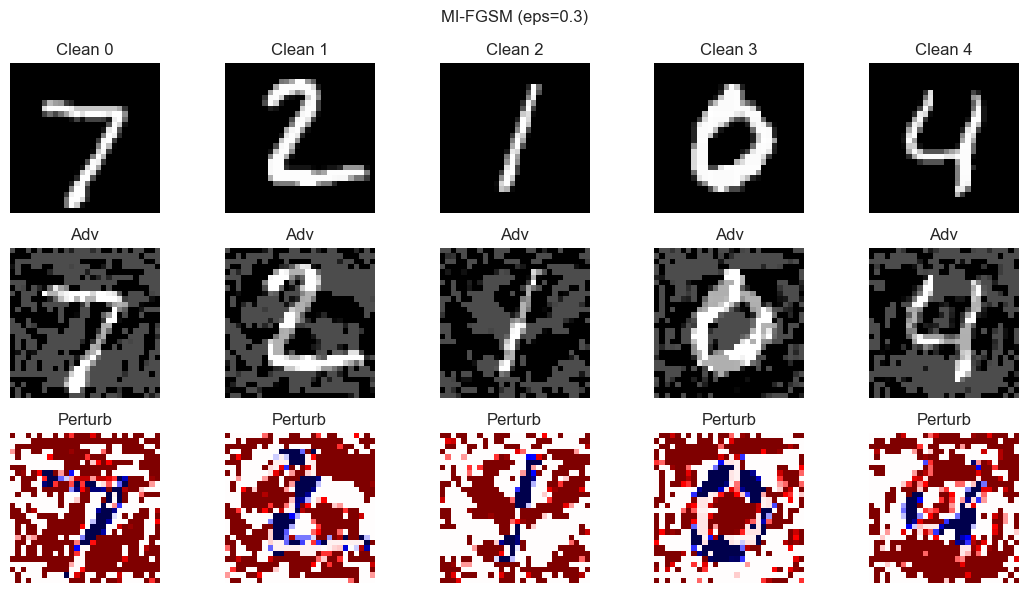

In [14]:

epsilon = 0.30
alpha = 0.03
steps = 20
decay = 1.0

def mifgsm_attack(model, x, y, eps, alpha, steps, decay=1.0):
    x_adv = x.detach().clone()
    momentum = torch.zeros_like(x)
    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad
        grad_norm = grad.view(grad.size(0), -1).abs().sum(dim=1, keepdim=True)
        grad_norm = torch.clamp(grad_norm, min=1e-12)
        momentum = decay * momentum + grad / grad_norm
        x_adv = x_adv + alpha * momentum.sign()
        x_adv = clamp_unit(x + project_linf(x_adv - x, eps)).detach()
    return x_adv

x_adv_mi = mifgsm_attack(model, x_test, y_test, epsilon, alpha, steps, decay=decay)
log_attack(f"MI-FGSM (eps={epsilon}, steps={steps})", x_adv_mi, notes="Momentum iterative FGSM")
visualize_examples(f"MI-FGSM (eps={epsilon})", x_adv_mi)



## DeepFool (L2)

Iteratively linearizes the classifier and steps toward the closest decision boundary for each sample.


processed 50 / 256 samples
processed 100 / 256 samples
processed 150 / 256 samples
processed 200 / 256 samples
processed 250 / 256 samples
DeepFool (L2) -> adv accuracy: 0.0000 | mean L_inf: 0.1350 | mean L2: 0.8077


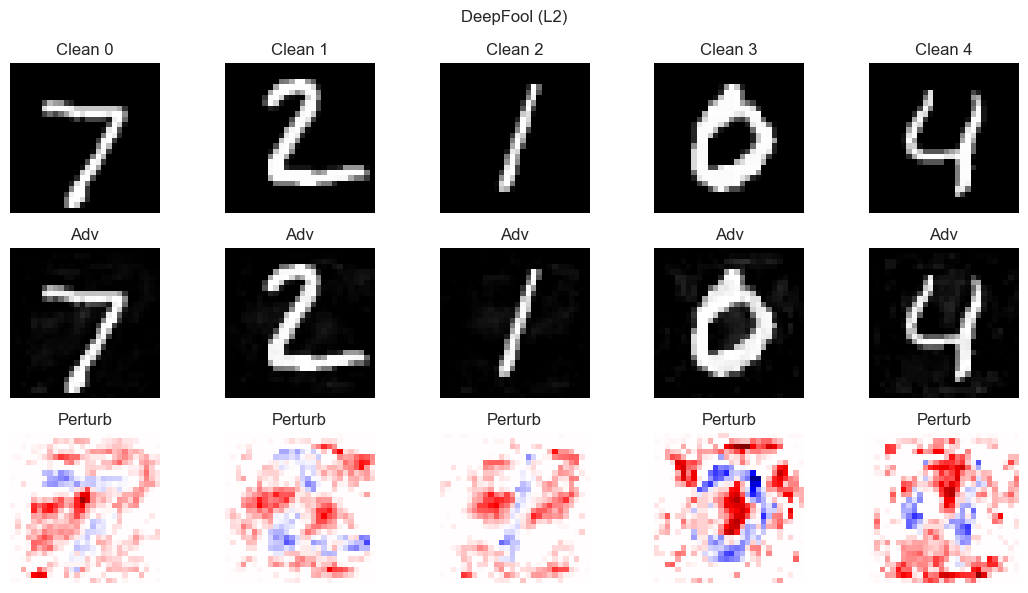

In [16]:

def deepfool_single(model, image, label, num_classes=10, overshoot=0.02, max_iter=50):
    model.eval()
    xi = image.clone().detach()
    label_idx = int(label.item()) if torch.is_tensor(label) else int(label)
    with torch.no_grad():
        pred = model(xi).argmax(dim=1)
    if pred.item() != label_idx:
        return torch.zeros_like(xi)
    r_tot = torch.zeros_like(xi)
    for _ in range(max_iter):
        x_adv = clamp_unit(xi + r_tot).detach().requires_grad_(True)
        logits = model(x_adv)
        current = logits.argmax(dim=1).item()
        if current != label_idx:
            break
        model.zero_grad()
        grad_orig = torch.autograd.grad(logits[0, label_idx], x_adv, retain_graph=True)[0]
        min_value = None
        w_best = None
        for k in range(num_classes):
            if k == label_idx:
                continue
            grad_curr = torch.autograd.grad(logits[0, k], x_adv, retain_graph=True)[0]
            w_k = grad_curr - grad_orig
            f_k = logits[0, k] - logits[0, label_idx]
            value = torch.abs(f_k) / (w_k.view(-1).norm() + 1e-12)
            if min_value is None or value < min_value:
                min_value = value
                w_best = w_k
        if w_best is None:
            break
        r_i = (min_value + 1e-6) * w_best / (w_best.view(-1).norm() + 1e-12)
        r_tot = r_tot + r_i
    adv_example = clamp_unit(xi + (1 + overshoot) * r_tot)
    return adv_example - xi

def deepfool_attack(model, x, y, num_classes=10, overshoot=0.02, max_iter=50):
    perturbations = []
    for idx in range(x.size(0)):
        delta = deepfool_single(model, x[idx:idx+1], y[idx:idx+1], num_classes=num_classes, overshoot=overshoot, max_iter=max_iter)
        perturbations.append(delta)
        if (idx + 1) % 50 == 0:
            print(f"processed {idx + 1} / {x.size(0)} samples")
    perturb = torch.cat(perturbations, dim=0)
    return clamp_unit(x + perturb)

x_adv_deepfool = deepfool_attack(model, x_test, y_test, num_classes=10, overshoot=0.02, max_iter=30)
log_attack("DeepFool (L2)", x_adv_deepfool, notes="Least-norm boundary attack")
visualize_examples("DeepFool (L2)", x_adv_deepfool)



## Carlini & Wagner $L_2$

Optimization-based attack that searches for the smallest $L_2$ perturbation capable of changing the prediction.


step 50/200 - loss 0.0011
step 100/200 - loss 0.0011
step 150/200 - loss 0.0011
step 200/200 - loss 0.0011
Carlini-Wagner L2 -> adv accuracy: 0.9688 | mean L_inf: 0.0004 | mean L2: 0.0013


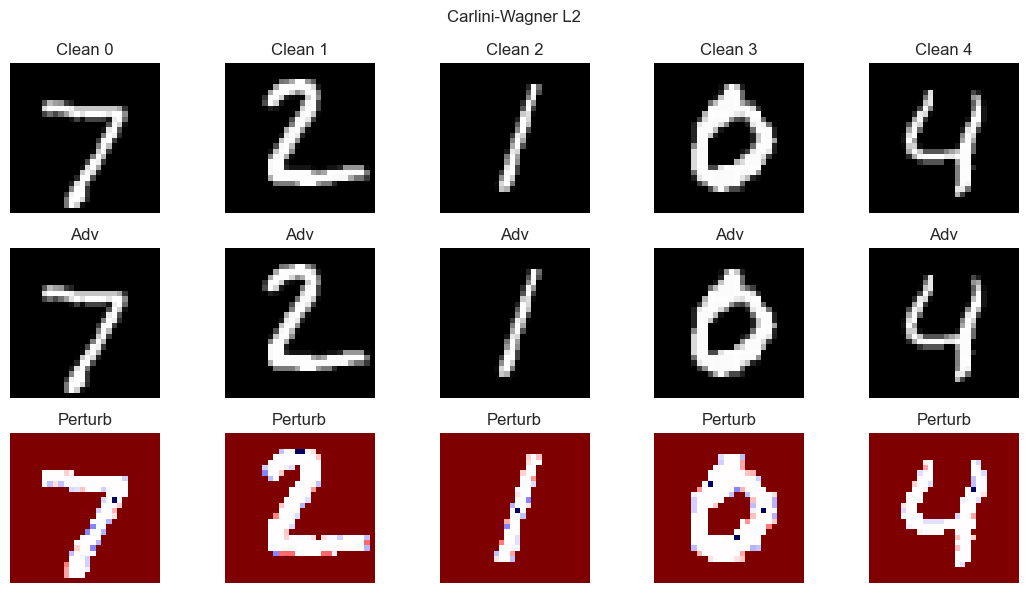

In [18]:

def arctanh(x):
    return 0.5 * torch.log((1 + x) / (1 - x))

def cw_l2_attack(model, x, y, c=1e-2, kappa=0.0, steps=250, lr=0.01):
    model.eval()
    x_orig = torch.clamp(x, 0.0, 1.0)
    x_scaled = x_orig * 2 - 1
    x_scaled = torch.clamp(x_scaled, -0.999999, 0.999999)
    w = arctanh(x_scaled)
    w = w.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([w], lr=lr)
    for step in range(steps):
        adv = torch.tanh(w) * 0.5 + 0.5
        logits = model(adv)
        one_hot = F.one_hot(y, num_classes=logits.shape[1]).float()
        real = torch.sum(one_hot * logits, dim=1)
        other = torch.max((1 - one_hot) * logits - one_hot * 1e4, dim=1)[0]
        f = torch.clamp(other - real + kappa, min=0)
        l2 = torch.sum((adv - x_orig) ** 2, dim=1)
        loss = (l2 + c * f).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (step + 1) % 50 == 0:
            print(f"step {step + 1}/{steps} - loss {loss.item():.4f}")
    adv = torch.tanh(w).detach() * 0.5 + 0.5
    return clamp_unit(adv)

cw_params = {"c": 1e-2, "kappa": 0.0, "steps": 200, "lr": 0.01}
x_adv_cw = cw_l2_attack(model, x_test, y_test, **cw_params)
log_attack("Carlini-Wagner L2", x_adv_cw, notes=f"Params: {cw_params}")
visualize_examples("Carlini-Wagner L2", x_adv_cw)



## NES Black-Box Attack

Approximates the gradient by querying Gaussian perturbations (NES) and applies an $L_\infty$ constrained update.


NES step 5/25
NES step 10/25
NES step 15/25
NES step 20/25
NES step 25/25
NES Black-Box -> adv accuracy: 0.4414 | mean L_inf: 0.1897 | mean L2: 1.7427


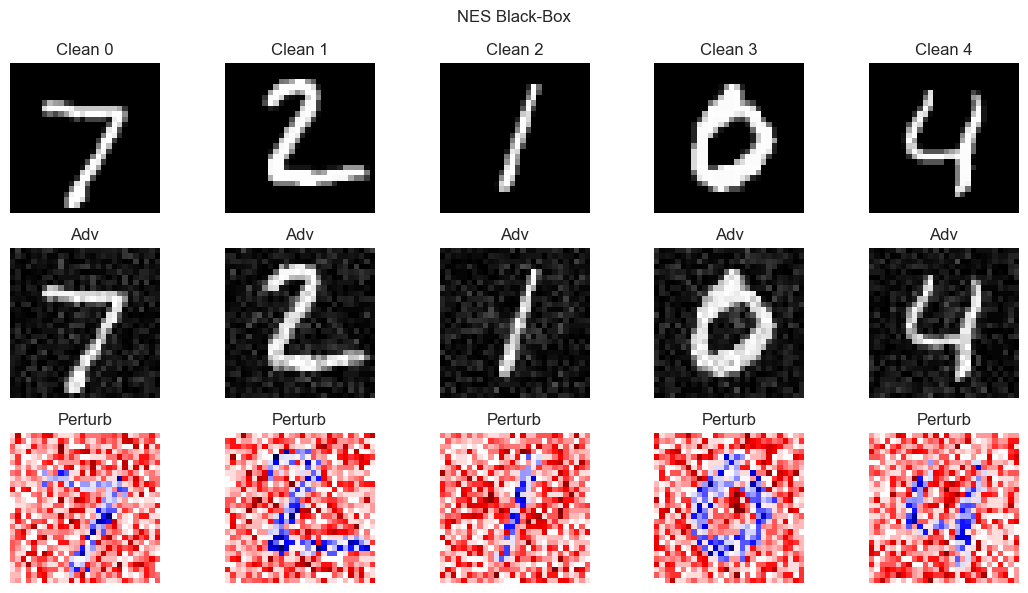

In [20]:

epsilon = 0.30
step_size = 0.02
steps = 25
samples = 8
sigma = 0.001

def nes_black_box_attack(model, x, y, eps, step_size, steps, sigma, samples):
    x_adv = x.detach().clone()
    for step in range(steps):
        grad_est = torch.zeros_like(x_adv)
        for _ in range(samples):
            noise = torch.randn_like(x_adv)
            x_plus = clamp_unit(x_adv + sigma * noise)
            x_minus = clamp_unit(x_adv - sigma * noise)
            with torch.no_grad():
                logits_plus = model(x_plus)
                logits_minus = model(x_minus)
            loss_plus = F.cross_entropy(logits_plus, y, reduction="none")
            loss_minus = F.cross_entropy(logits_minus, y, reduction="none")
            grad_est += ((loss_plus - loss_minus).unsqueeze(1) * noise) / (2 * sigma)
        grad_est /= samples
        x_adv = x_adv + step_size * grad_est.sign()
        x_adv = clamp_unit(x + project_linf(x_adv - x, eps)).detach()
        if (step + 1) % 5 == 0:
            print(f"NES step {step + 1}/{steps}")
    return x_adv

x_adv_nes = nes_black_box_attack(model, x_test, y_test, epsilon, step_size, steps, sigma, samples)
log_attack("NES Black-Box", x_adv_nes, notes="Gradient-free NES estimate")
visualize_examples("NES Black-Box", x_adv_nes)



## Universal $L_\infty$ Perturbation

Builds a single perturbation vector that fools most inputs by iteratively aggregating DeepFool directions.


Iteration 1 -> fooling rate 0.4180
Iteration 2 -> fooling rate 0.3594
Iteration 3 -> fooling rate 0.3555
Iteration 4 -> fooling rate 0.3594
Iteration 5 -> fooling rate 0.3633
Universal L_inf Perturbation -> adv accuracy: 0.6367 | mean L_inf: 0.2000 | mean L2: 3.2246


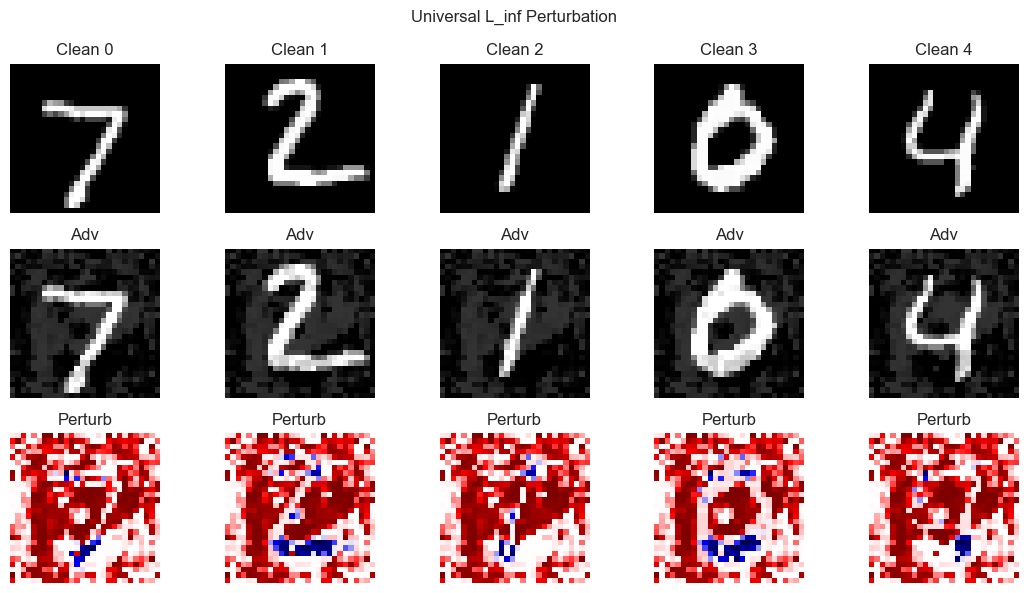

In [22]:

def universal_linf_attack(model, x, y, xi=0.2, delta=0.2, max_iter=5, overshoot=0.02, max_df_iter=15):
    v = torch.zeros((1, x.size(1)), device=x.device)
    iteration = 0
    fooling_rate = 0.0
    while iteration < max_iter and fooling_rate < 1 - delta:
        for idx in range(x.size(0)):
            current = x[idx:idx+1]
            label = y[idx:idx+1]
            with torch.no_grad():
                pred = model(clamp_unit(current + v)).argmax(dim=1)
            if pred.item() == label.item():
                delta_i = deepfool_single(model, clamp_unit(current + v), label, overshoot=overshoot, max_iter=max_df_iter)
                v = project_linf(v + delta_i, xi)
        with torch.no_grad():
            adv = clamp_unit(x + v)
            preds = model(adv).argmax(dim=1)
            fooling_rate = (preds != y).float().mean().item()
        iteration += 1
        print(f"Iteration {iteration} -> fooling rate {fooling_rate:.4f}")
    return clamp_unit(x + v)

universal_params = {"xi": 0.2, "delta": 0.2, "max_iter": 5, "overshoot": 0.02, "max_df_iter": 12}
x_adv_universal = universal_linf_attack(model, x_test, y_test, **universal_params)
log_attack("Universal L_inf Perturbation", x_adv_universal, notes=f"Params: {universal_params}")
visualize_examples("Universal L_inf Perturbation", x_adv_universal)



## Summary

Aggregate the metrics for quick comparison across attacks.


In [24]:

summary_df = pd.DataFrame.from_dict(attack_results, orient="index")
summary_df = summary_df.sort_values("adv_acc")
summary_df


,clean_acc,adv_acc,avg_linf,avg_l2,notes
"PGD (eps=0.3, steps=40, restarts=5)",0.964844,0.000000,0.300000,5.976929,Madry PGD with random restarts
DeepFool (L2),0.964844,0.000000,0.135015,0.807671,Least-norm boundary attack
"MI-FGSM (eps=0.3, steps=20)",0.964844,0.003906,0.300000,5.901176,Momentum iterative FGSM
"BIM (eps=0.25, alpha=0.03, steps=10)",0.964844,0.003906,0.250000,4.236865,Iterative FGSM / Basic iterative attack
FGSM (eps=0.25),0.964844,0.109375,0.250000,5.334750,One-step untargeted attack
NES Black-Box,0.964844,0.441406,0.189688,1.742681,Gradient-free NES estimate
Universal L_inf Perturbation,0.964844,0.636719,0.200000,3.224620,"Params: {'xi': 0.2, 'delta': 0.2, 'max_iter': ..."
Carlini-Wagner L2,0.964844,0.968750,0.000360,0.001275,"Params: {'c': 0.01, 'kappa': 0.0, 'steps': 200..."
